--- 
Project for the course "Open Source Economics" | Winter term 2021/22, M.Sc./Ph.D. Economics, University of Bonn | [Alexandros Gilch](https://github.com/alexandrosgi)

# Implementation of the course project of the Mitsui Center Summer School 2021  <a class="tocSkip">   
Ross School of Business, University of Michigan  <a class="tocSkip">  
Organizers:  <a class="tocSkip">  
Toni Whited, University of Michigan  <a class="tocSkip">  
Luke Taylor, University o Pennsylvania
---

### Meeting 2021/12/21 2.45 pm

Questions:

- theoretical background enough? Should focus rather on model or estimation method?
- how much explanations additional to code really necessary? Rather focus on code documentation or on interpretation of results?
- Code:
    - Structure: Are classes the right way to go? When, when not?
    - Should we try to use numba? Apparently we would need to go back to for-loops for that
    - What about pandas? We do not use as much data as example project and present less of it. Also we fear performance issues. On the other hand it is nicer to handle and display.
- In general: How much effort should go into this project? FOr us it is more like a toy project to have a base implementation of a structural model and the corresponding estimation, in order to obtain some experience for future research and the possible development of such models.

---
# 0. Abstract 
---

We implement the structural estimation of a workhorse model in Corporate Finance which may serve as base implementation for future developments of structural finance models and their implementation. The project is written in Python 

- needs to be further developed for better software structure and usage of Python/Numpy components
- performance enhancements through better code or proper usage of code necessary
- Results are not very surprising and primarily serve as sanity check of the implementation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#0.-Abstract" data-toc-modified-id="0.-Abstract-0">0. Abstract</a></span></li>
    <li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li>
    <li><span><a href="#2.-Theoretical-Background" data-toc-modified-id="2.-Theoretical-Background-2">2. Theoretical Background: Structural Estimation</a></span></li>
    <li><span><a href="#3.-Theoretical-Background" data-toc-modified-id="3.-Theoretical-Background-3">3. Theoretical Background: Corporate Finance Workhorse Model</a></span></li>
    <li><span><a href="#4.-Solution" data-toc-modified-id="4.-Solution-4">4. Solving the model</a></span><ul class="toc-item">
        <li><span><a href="#4.1.-Solution" data-toc-modified-id="4.1.-Solution-4.1">4.1. Solution</a></span></li>
        <li><span><a href="#4.2.-Implementation" data-toc-modified-id="4.2.-Implementation-4.2">4.2. Implementation</a></span></li>
    </ul></li>
    <li><span><a href="#5.-Results" data-toc-modified-id="5.-Results-5">5. Results</a></span><ul class="toc-item">
        <li><span><a href="#5.1.-Tests-of-the-Validity-of-the-RD-Approach" data-toc-modified-id="5.1.-Tests-of-the-Validity-of-the-RD-Approach-5.1">4.2.1. Tests of the Validity of the RD Approach</a></span></li>
        <li><span><a href="#5.2.-First-Year-GPAs-and-Academic-Probation" data-toc-modified-id="5.2.-First-Year-GPAs-and-Academic-Probation-5.2">4.2.2. First Year GPAs and Academic Probation</a></span></li>
        <li><span><a href="#5.3.-The-Immediate-Response-to-Academic-Probation" data-toc-modified-id="5.3.-The-Immediate-Response-to-Academic-Probation-5.3">4.2.3. The Immediate Response to Academic Probation</a></span></li>
    </ul></li>
    <li><span><a href="#6.-Conclusion" data-toc-modified-id="6.-Conclusion-6">6. Conclusion</a></span></li>
    <li><span><a href="#7.-References" data-toc-modified-id="7.-References-7">7. References</a></span></li>
</ul></div>

In [2]:
import numpy as np
from auxiliary.Model import Model

---
# 1. Introduction <a id="#1.-Introduction"></a>
---

In the following we present the implementation as well as the results of the course project at last years Mitsui Center Summer School at the Ross School of Business, University of Michigan. The main goal of this summer school was to introduce PhD students in the fields of finance and business to some methods from the field of structural estimation and provide them the opportunity to implement these methods on their own for a workhorse model from Corporate Finance.

- Structural estimation as important tool to try to identify causal relations in economic phenomenons and calculate economically relevant parameters.
- Corp Fin model, dynamic model, basic components, requires simulation, want to estimate real economic parameters $\alpha,\ \delta$
- Preview results: Present and interpret value+policy functions, analyze strength of several moments for estimation, consider real moments, estimate models (maybe with different setups?), some robustness and confidence intervals

This notebook is structured as follows: In the next section, we present the basic components necessary for the structural estimation of a generic dynamic model. In section 3, we specify the considered model and shortly describe its context in the corporate finance literature. Section 4 covers the major part of the analysis: In section 4.1, we describe the implementation of model and estimation. Section 4.2 finally continues with the results derived from the estimation. Section 5 concludes this notebook.

---
# 2. Theoretical Background: Structural estimation 
---

As economic researcher we are interested in understanding complex and often dynamic interactions and decisions of economic agents. For that matter, we consider a generic economic model which starts with some assumptions about agents' preferences, their possible choices and constraints, a notion of equilibrium and so on. Based on these components for which we also would like to have real world data, the model makes predictions about the relation of observable, often endogenous variables. 

- Assume we have a economic model --> want to model complex/dynamic interactions/decisions of agents over time
    - agent's preferences
    - (budget) constraints
    - firm's prod function
    - equilibrium, ...
    --> want to make predictions about observable (endogenous) variables
- SE
    - estimate model parameter and assess model fit (using and to real data)
    - in particular not only some correlation parameters, but "real" economic parameters
- Se vs reduced-form
    - RF: find causal effect X on Y (need correlation and exogeneity)
    - SE: Why does X affect Y?, economic primitives not just some slopes, may construct/examine counterfactuals
- Model for SE should be "realistic", more than 2 states, more than 2 periods
- Estimators particularly include Maximum Likelihood and GMM
- May need simulated/approximated versions if no closed-form solution exists
- (Calibration vs SE --> not really important for this project, also I don't fully understand the difference)
- 
- Reduced form model/estimation cannot 
- Def GMM estimator
- Properties, advantages GMM estimator --> what is it used for?


---
# 3. Theoretical Background: Corporate Finance Workhorse Model
---

- firm-manager maximizes expected PV of shareholders
- Setup
    - infinite-horizon, discrete-time environment
    - decreasing returns production technology generates income $zK^\alpha$
    - profitability shocks $z$, lognormally distributed with AR(1) process
    - investment $I$ chosen based on standard capital stock accounting identity:
        $K'=(1-\delta)K+I$ 
    - firm cash flow $E^*$, shareholder cash flow $E$ is firm CF, adjusted if $E^*$ negative
    - ==> get intertemporal firm maximization problem, given parameters $\alpha, \delta$
- get some literature?
    - who wrote it?
    - where is it being used?
    - what are natural applications/extensions?

---
# 4. Model Solution and Implementation
---

## 4.1 Solution methods
- Model constitutes dynamic programming problem
    - discretize shock and capital space
    - value and policy function iteration to solve for optimal capital choice given any capital endowment and shock state
    - 
- Want to estimate parameters $\alpha, \delta$ with GMM
    - are interesting economic primitives and might be interesting for other models as well. Could also be compared to results from other papers
    - need to determine moments to match
    - model does not have closed form solution --> need to simulate time series to obtain model moments 
    - hence have MSM instead of GMM estimator
- Data
    - have basic data set with n firms (identified by id) for $T_i\in\{x\}$ time periods (years)
    - 2 variables provided: profitability, investment rate
    - Provide some summary statistics of data

## 4.2 Implementation
- model setup, solution, simulation integrated in 1 class object
    - object orientation as a way to better structure the code
    - only certain functions for visualization designated for use from "outside"
    - parallel creation of instances with different parameters possible to compare performances
    - nice to have if high performance (e.g. for high accuracy or high number of simulations) not main goal
- data usage
    - 5 possible (reasonable) moments (generalized notion off moments): mean, var of both plus coefficients of regressing one var on the other one
    - use demeaned data (firm and time fixed effects) 

---
# 5. Results
---

## 5.1 Value and Policy functions
- Plot value and policy function for base parametrization $\alpha=0.5, \delta=0.05$
- Interpret results shortly
    - for high productivity capital is generally higher --> firms may accumulate more capital over time
    - capital choice: there are maximal and minimal capital choices which provide boundaries for the chosen capital in the next period
        - These boundaries depend on the productivity shock --> low productivity leads to lower boundaries, high productivity to higher boundaries
        - Interpretation: no matter how high the current capital, given the shock, it doesn't make sense to have more capital next period than upper bound. More capital won't be more productive than just paying out shareholders this period. On the other side, it always makes sense to achieve at least the lower bound and demand reinvestments from the shareholders.
- Investigate changes of plots with $\alpha, \delta$
    - what to do here?

## 5.2 Identification strategy

- Show visualization of sensitivities of moments to changes in $\alpha, \delta$
- Interpretation
    - Certain moments/moment combinations are better suited for GMM than others, since they don't move in the same direction
- 

## 5.3 Comparing optimizers and robustness to noisy functions

In [3]:

deep_param = {
    "beta" : 0.96,
    "gamma": 0.04, # corresponds to lambda in project description
    "rho" : 0.75, 
    "sigma" : 0.15
}

discretization_param = {
    "size_shock_grid" : 11, 
    "range_shock_grid" : 2.575
}

approx_param = {
    "max_iter" : 1000, 
    "precision" : 1e-5, 
    "size_capital_grid" : 101, 
}

sim_param = {
    "number_firms" : 100, 
    "number_simulations_per_firm" : 1, 
    "number_years_per_firm" : 10, 
    "burnin" : 200, 
    "seed" : 10082021
}

alpha_default, delta_default = 0.5190, 0.0437
visualization_param = {
    "alpha grid bounds" : (0.35, 0.65), 
    "delta grid bounds" : (0.025,0.065),
    "fixed alpha" : alpha_default, 
    "fixed delta" : delta_default, 
    "parameter grid size" : 20
}

In [4]:
model = Model(deep_param, discretization_param, approx_param)

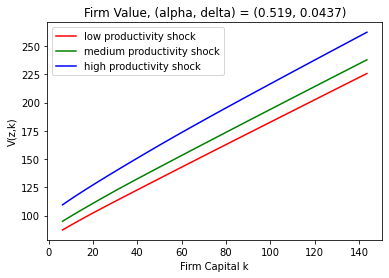

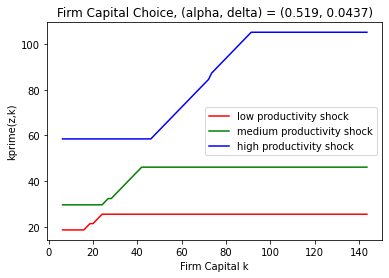

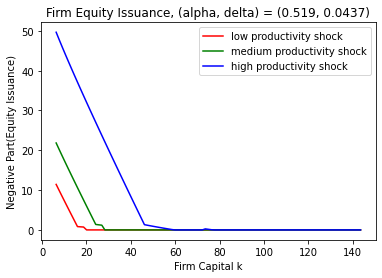

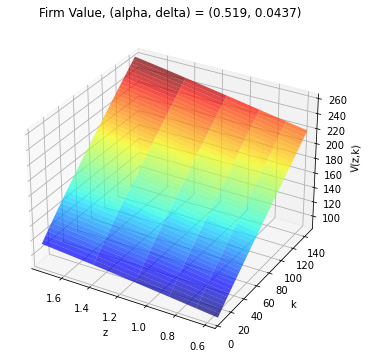

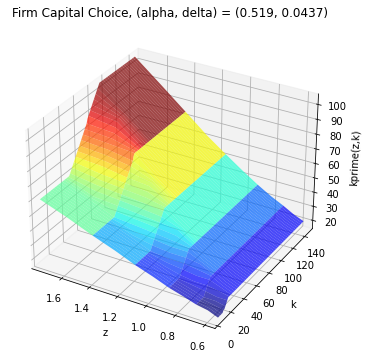

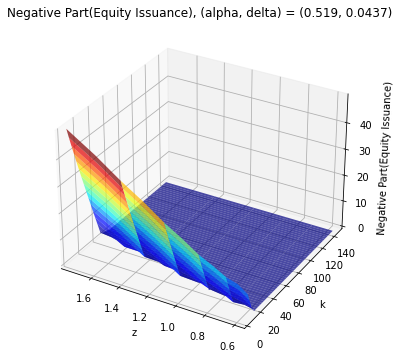

In [5]:
model.visualize_model_sol(alpha_default, delta_default)

25 ( 0.0004052827600560249  error)


Converged in 37  iterations with error  7.252422605574793e-06
25 ( 0.00043998052141347443  error)


Converged in 37  iterations with error  7.873312981132585e-06
25 ( 0.00048006671698175296  error)


Converged in 37  iterations with error  8.590620225845669e-06
25 ( 0.000527181399789356  error)


Converged in 37  iterations with error  9.43370299921753e-06
25 ( 0.0005820826609621577  error)


Converged in 38  iterations with error  7.449084279187446e-06
25 ( 0.0006477745374340316  error)


Converged in 38  iterations with error  8.289752528867211e-06
25 ( 0.0007253656737873371  error)


Converged in 38  iterations with error  9.282684104050531e-06
25 ( 0.000819792264849184  error)


Converged in 39  iterations with error  7.502695538619264e-06
25 ( 0.0009335798144149976  error)


Converged in 39  iterations with error  8.544065423166103e-06
25 ( 0.0010733581393793656  error)


Converged in 39  iterations with error  9.82329851240138e-06
25 ( 0.00124

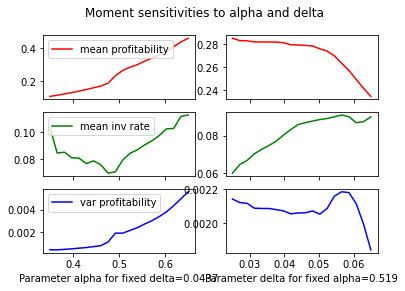

In [6]:
model.visualize_mom_sensitivity(visualization_param, sim_param)